In [1]:
### Quantification frequency analysis ###
# all combined data sets

# Import required packages
library(alakazam)
library(shazam)
library(dplyr)
library(ggplot2)

require(data.table)
db <- as.data.frame(fread("../../changeo_10x/copy_a_r_vac_wt.tsv"))

Loading required package: ggplot2

As of v1.0.0 the AIRR Rearrangement schema is now the default file format.
A description of the standard is available at https://docs.airr-community.org.
The legacy Change-O format is supported through arguments to each function
that allow the input column names to be explicitly defined.

As of v1.0.0 the AIRR Rearrangement schema is now the default file format.
A description of the standard is available at https://docs.airr-community.org.
The legacy Change-O format is supported through arguments to each function
that allow the input column names to be explicitly defined.


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [2]:
# Collapse clonal groups into single sequences
clones <- collapseClones(db, cloneColumn="clone_id", 
                         sequenceColumn="sequence_alignment", 
                         germlineColumn="germline_alignment_d_mask", 
                         regionDefinition=IMGT_V, 
                         method="thresholdedFreq", minimumFrequency=0.6,
                         includeAmbiguous=FALSE, breakTiesStochastic=FALSE, 
                         nproc=1)

In [4]:
# Count observed mutations and append mu_count columns to the output
observed <- observedMutations(clones, 
                              sequenceColumn="clonal_sequence",
                              germlineColumn="clonal_germline",
                              regionDefinition=IMGT_V, nproc=1)

# Count expected mutations and append mu_exptected columns to the output
expected <- expectedMutations(observed, 
                              sequenceColumn="clonal_sequence",
                              germlineColumn="clonal_germline",
                              targetingModel=HH_S5F,
                              regionDefinition=IMGT_V, nproc=1)

In [6]:
# Calculate selection scores using the output from expectedMutations
baseline_expected <- calcBaseline(expected, testStatistic="focused", 
                         regionDefinition=IMGT_V, nproc=1)

calcBaseline will use existing observed and expected mutations, in the fields: mu_count_cdr_r, mu_count_cdr_s, mu_count_fwr_r, mu_count_fwr_s and mu_expected_cdr_r, mu_expected_cdr_s, mu_expected_fwr_r, mu_expected_fwr_s



Calculating BASELINe probability density functions...


In [7]:
# Calculate selection scores from scratch
baseline_clones <- calcBaseline(clones, testStatistic="focused", 
                         regionDefinition=IMGT_V, nproc=1)

calcBaseline will calculate observed and expected mutations for clonal_sequence using clonal_germline as a reference.



Calculating BASELINe probability density functions...


In [21]:
# Combine selection scores by time-point
grouped_1 <- groupBaseline(baseline_clones, groupBy="sample_id")

Grouping BASELINe probability density functions...
Calculating BASELINe statistics...


In [22]:
# Subset the original data to switched isotypes
db_sub <- subset(db, c_call %in% c("IGHM", "IGHG", "IGHD", "IGHA"))

# Collapse clonal groups into single sequence
clones_sub <- collapseClones(db_sub, cloneColumn="clone_id",
                             sequenceColumn="sequence_alignment",
                             germlineColumn="germline_alignment_d_mask",
                             regionDefinition=IMGT_V, 
                             method="thresholdedFreq", minimumFrequency=0.6,
                             includeAmbiguous=FALSE, breakTiesStochastic=FALSE, 
                             nproc=1)

# Calculate selection scores from scratch
baseline_sub <- calcBaseline(clones_sub, testStatistic="focused", 
                             regionDefinition=IMGT_V, nproc=1)

# Combine selection scores by time-point and isotype
grouped_2 <- groupBaseline(baseline_sub, groupBy=c("sample_id", "c_call"))

calcBaseline will calculate observed and expected mutations for clonal_sequence using clonal_germline as a reference.



Calculating BASELINe probability density functions...
Grouping BASELINe probability density functions...
Calculating BASELINe statistics...


In [23]:
# First group by subject and status
subject_grouped <- groupBaseline(baseline_sub, groupBy=c("status", "subject"))

# Then group the output by status
status_grouped <- groupBaseline(subject_grouped, groupBy="status")

ERROR: Error in `[.data.frame`(baseline@db, , groupBy): undefined columns selected


In [24]:
testBaseline(grouped_1, groupBy="sample_id")

region,test,pvalue,fdr
<chr>,<chr>,<dbl>,<dbl>
cdr,a != r,0.41781597,0.4178160
cdr,a != vac,0.11870634,0.2374127
cdr,a != wt,0.05840889,0.1752267
cdr,r != vac,0.08853409,0.2124818
cdr,r != wt,0.04287205,0.1752267
cdr,vac != wt,0.33298331,0.3995800
fwr,a != r,0.04429627,0.1752267
fwr,a != vac,0.26574308,0.3543241
fwr,a != wt,0.40487869,0.4178160


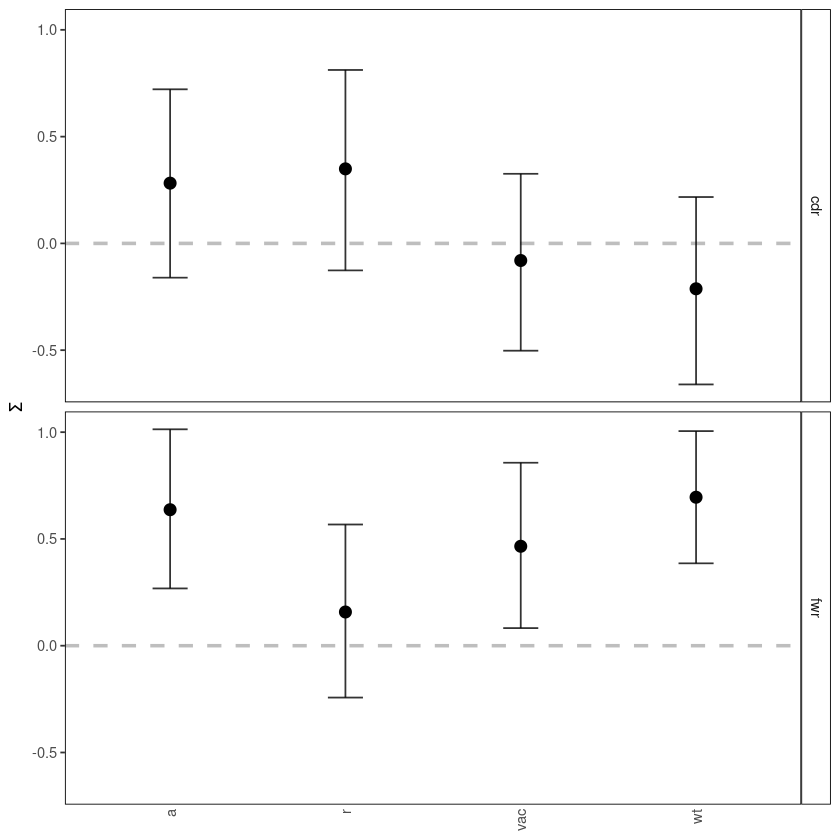

In [42]:
# Set sample and isotype colors
sample_colors <- c("a"="seagreen", "r"="deeppink1", "vac"="gold3", "wt"="black")
isotype_colors <- c("IGHM"="darkorchid", "IGHD"="firebrick", 
                    "IGHG"="seagreen", "IGHA"="steelblue")

# Plot mean and confidence interval by time-point
plotBaselineSummary(grouped_1, "sample_id")

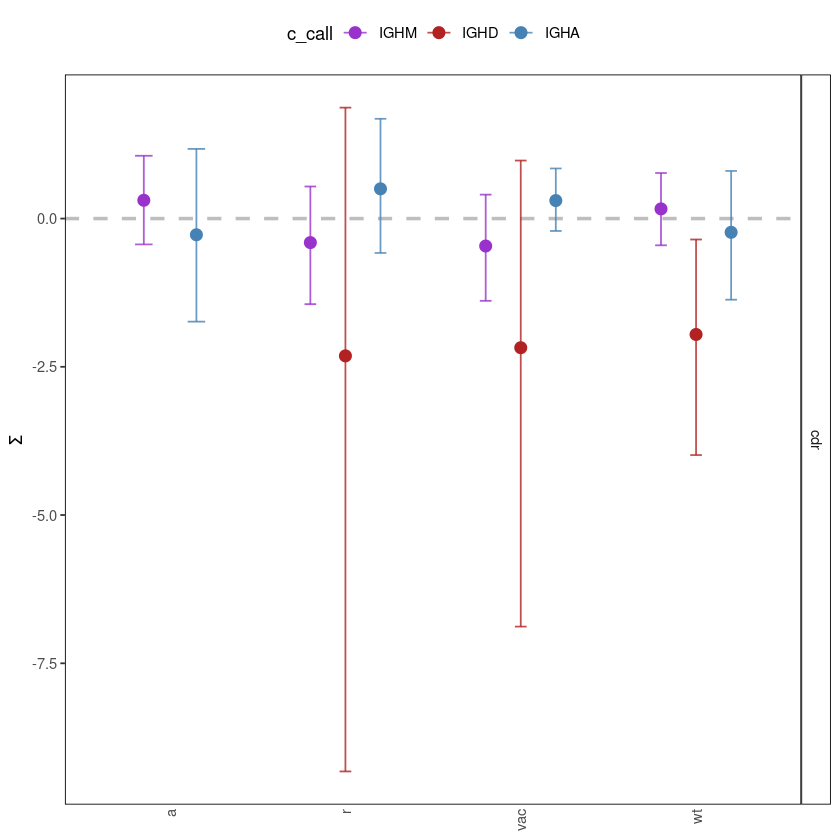

In [43]:
# Plot selection scores by time-point and isotype for only CDR
plotBaselineSummary(grouped_2, "sample_id", "c_call", groupColors=isotype_colors,
                    subsetRegions="cdr")

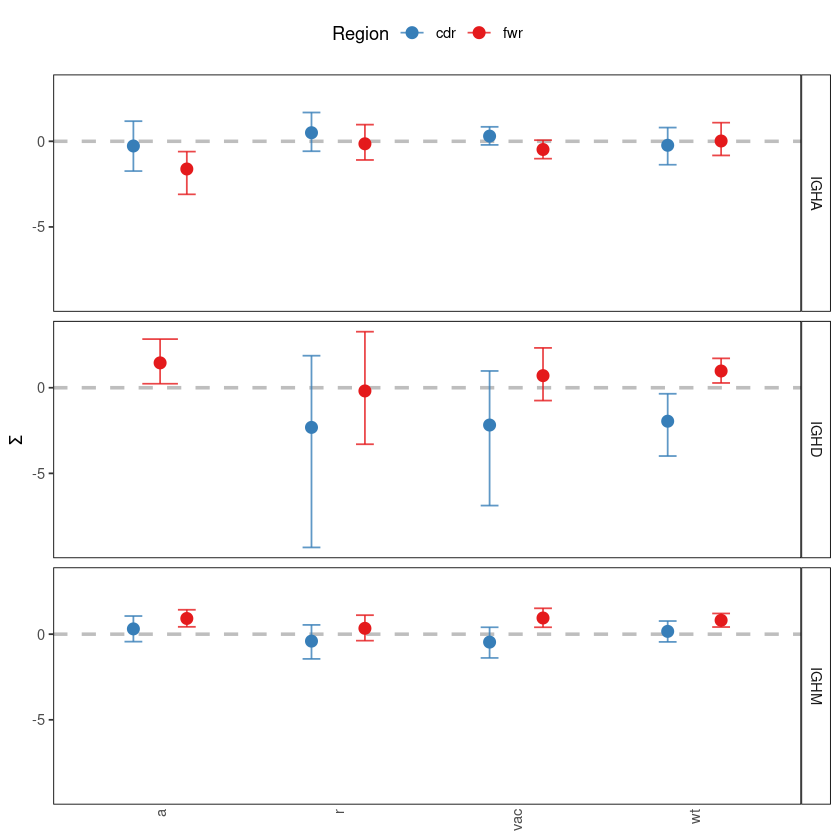

In [44]:
# Group by CDR/FWR and facet by isotype
plotBaselineSummary(grouped_2, "sample_id", "c_call", facetBy="group")

Warning message:
“Removed 301 row(s) containing missing values (geom_path).”


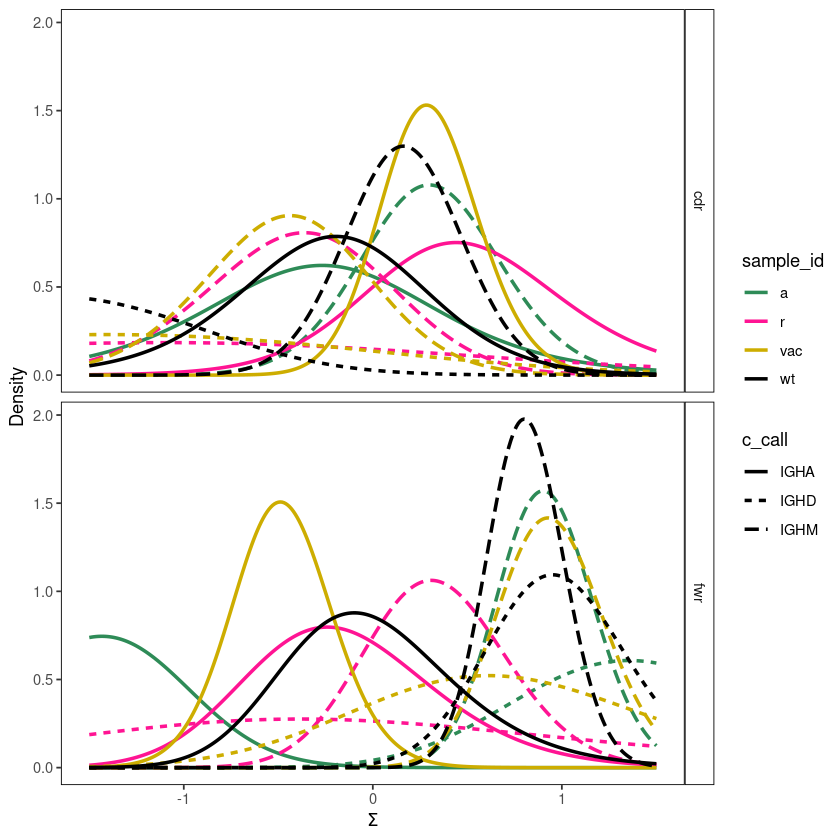

In [46]:
# Plot selection PDFs for a subset of the data
plotBaselineDensity(grouped_2, "c_call", groupColumn="sample_id", colorElement="group", 
                    colorValues=sample_colors, sigmaLimits=c(-1.5, 1.5))